# **Project InsightAds**  
### **Digital-Marketing-Performance-Analysis**

**Team Name** : Nova  
**Members** : 'Izzah Huwaidah (Ketua), Ashma Nisa Sholihah Adma   
**Competition** : inSight Data – Data Analyst Competition  
**Date** : January - February 2026


## **Latar Belakang**

Periklanan digital merupakan salah satu strategi utama dalam meningkatkan 
brand awareness dan penjualan. Namun, peningkatan anggaran iklan tidak selalu 
diikuti dengan peningkatan performa yang sebanding. Oleh karena itu, diperlukan 
analisis data yang komprehensif untuk mengevaluasi efektivitas iklan, mengidentifikasi 
pola performa, serta menemukan peluang optimasi berbasis data.


## **Deskripsi Dataset**

Dataset yang digunakan berisi data performa iklan digital yang mencakup metrik 
seperti impressions, clicks, content views, add to cart, purchases, biaya iklan, 
serta nilai pembelian. Data ini digunakan untuk menganalisis efektivitas iklan 
berdasarkan berbagai objective kampanye dan periode waktu tertentu.


## **Impor Library and Load Data**

In [122]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [123]:
df = pd.read_csv("Data Ads - Kompetisi Data Analyts by inSight Data Batch 01.csv")

## **Data Cleaning and Preparation** (kalo emang perlu nanti)

In [124]:
df.head()

,created_date,account_name,campaign_objective,impressions,reach,clicks,link_clicks,content_views,add_to_cart,purchase,purchase_value,amount_spent
0,2023-01-01,Client A - Fashion,Traffic,915434.0,81436.0,92554.0,15544.0,0.0,0.0,0.0,0.0,2357742.0
1,2023-01-01,Client A - Fashion,Sales,103328.0,89200.0,22100.0,38038.0,1199.0,817.0,824.0,3353702.0,3578529.0
2,2023-01-01,Client B - Beauty,Traffic,336015.0,141082.0,26321.0,46107.0,0.0,0.0,0.0,0.0,1482711.0
3,2023-01-01,Client B - Beauty,Sales,864410.0,400596.0,10719.0,29397.0,3395.0,960.0,591.0,3470984.0,4335272.0
4,2023-01-01,Client C - Fashion,Traffic,916254.0,319415.0,32995.0,37496.0,0.0,0.0,0.0,0.0,1897353.0


In [125]:
df.shape

(4380, 12)

In [126]:
# checking for null values
df.isnull().sum()

created_date          0
account_name          0
campaign_objective    0
impressions           0
reach                 0
clicks                0
link_clicks           0
content_views         0
add_to_cart           0
purchase              0
purchase_value        0
amount_spent          0
dtype: int64

In [127]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4380 entries, 0 to 4379
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   created_date        4380 non-null   object 
 1   account_name        4380 non-null   object 
 2   campaign_objective  4380 non-null   object 
 3   impressions         4380 non-null   float64
 4   reach               4380 non-null   float64
 5   clicks              4380 non-null   float64
 6   link_clicks         4380 non-null   float64
 7   content_views       4380 non-null   float64
 8   add_to_cart         4380 non-null   float64
 9   purchase            4380 non-null   float64
 10  purchase_value      4380 non-null   float64
 11  amount_spent        4380 non-null   float64
dtypes: float64(9), object(3)
memory usage: 410.8+ KB


In [128]:
df.columns

Index(['created_date', 'account_name', 'campaign_objective', 'impressions',
       'reach', 'clicks', 'link_clicks', 'content_views', 'add_to_cart',
       'purchase', 'purchase_value', 'amount_spent'],
      dtype='object')

In [129]:
# Ekstrak data tambahan (Regex)
df['industry'] = df['account_name'].str.extract(r'- (\w+)')[0]
df['client'] = df['account_name'].str.extract(r'(Client [A-Z])')[0]



In [130]:
# =========================
# 2) TRIM & NORMALISASI TEKS
# =========================
for col in ["account_name", "campaign_objective"]:
    df[col] = df[col].astype(str).str.strip()

# Normalisasi nilai objective (biar konsisten: Traffic/Sales)
df["campaign_objective"] = (
    df["campaign_objective"]
      .str.lower()
      .replace({
          "traffic ": "traffic",
          " sales": "sales",
          "conversion": "sales",
          "conversions": "sales"
      })
)

# Pakai title-case biar enak di laporan
df["campaign_objective"] = df["campaign_objective"].str.title()


In [131]:
# =========================
# 3) KONVERSI TIPE TANGGAL
# =========================
df["created_date"] = pd.to_datetime(df["created_date"], errors="coerce")

# Jika ada tanggal yang gagal diparse → cek
bad_date = df["created_date"].isna().sum()
print("Tanggal gagal parse:", bad_date)
# Kalau bad_date > 0, nanti kita inspeksi barisnya:
# display(df[df["created_date"].isna()].head())

Tanggal gagal parse: 0


In [132]:
# =========================
# 4) KONVERSI KOLOM ANGKA (SAFE COERCE)
# =========================
num_cols = [
    "impressions","reach","clicks","link_clicks","content_views",
    "add_to_cart","purchase","purchase_value","amount_spent"
]

for c in num_cols:
    # bersihin kalau ada pemisah ribuan koma, dll.
    df[c] = (
        df[c]
          .astype(str)
          .str.replace(",", "", regex=False)
          .str.replace(" ", "", regex=False)
    )
    df[c] = pd.to_numeric(df[c], errors="coerce")



In [133]:
# =========================
# 5) HANDLE MISSING VALUES (SIMPLE & MASUK AKAL)
# =========================
# Karena metrik ads umumnya "0 berarti tidak ada event", missing biasanya diperlakukan 0.
df[num_cols] = df[num_cols].fillna(0)

# Untuk text: jika ada kosong, isi "Unknown" biar tidak hilang
df["account_name"] = df["account_name"].replace({"nan": np.nan}).fillna("Unknown")
df["campaign_objective"] = df["campaign_objective"].replace({"Nan": np.nan, "nan": np.nan}).fillna("Unknown")



In [134]:
# =========================
# 6) DROP DUPLICATES (HATI-HATI)
# =========================
# Dataset kamu: "1 baris = 1 campaign per hari per klien" (berdasarkan guidebook)
# Tapi karena kita nggak punya kolom campaign_id/name, paling aman:
# - cek duplikat full-row dulu
before = df.shape[0]
df = df.drop_duplicates()
after = df.shape[0]
print(f"Duplikat full-row yang dibuang: {before - after}")



Duplikat full-row yang dibuang: 0


In [135]:
# =========================
# 7) BASIC VALIDATION / SANITY CHECK (TANPA OUTLIER DULU)
# =========================

# (a) Nilai negatif harusnya tidak ada
neg_counts = (df[num_cols] < 0).sum().sort_values(ascending=False)
print("\nJumlah nilai negatif per kolom:")
print(neg_counts[neg_counts > 0])

# (b) Cek logika funnel minimal (boleh ada edge-case, tapi ini buat flag aja)
# Catatan: clicks kadang bisa > impressions di sebagian platform kalau definisinya beda,
# tapi umumnya: impressions >= clicks >= link_clicks dan link_clicks >= purchase.
flags = pd.DataFrame({
    "clicks_gt_impressions": df["clicks"] > df["impressions"],
    "link_clicks_gt_clicks": df["link_clicks"] > df["clicks"],
    "purchase_gt_link_clicks": df["purchase"] > df["link_clicks"],
    "reach_gt_impressions": df["reach"] > df["impressions"],
    "purchase_value_positive_but_purchase_zero": (df["purchase_value"] > 0) & (df["purchase"] == 0),
    "spent_zero_but_has_activity": (df["amount_spent"] == 0) & ((df["impressions"] > 0) | (df["clicks"] > 0) | (df["purchase"] > 0)),
})

print("\nJumlah baris ter-flag (sanity):")
print(flags.sum().sort_values(ascending=False))

# Jika mau lihat contoh baris bermasalah:
# display(df[flags.any(axis=1)].head(20))




Jumlah nilai negatif per kolom:
Series([], dtype: int64)

Jumlah baris ter-flag (sanity):
link_clicks_gt_clicks                        870
reach_gt_impressions                         845
clicks_gt_impressions                          0
purchase_gt_link_clicks                        0
purchase_value_positive_but_purchase_zero      0
spent_zero_but_has_activity                    0
dtype: int64


In [136]:
# =========================
# 8) FEATURE PREP BUAT ANALISIS (OPSIONAL TAPI BERGUNA)
# =========================
# Tambah kolom bulan untuk trend
df["year"] = df["created_date"].dt.year
df["month"] = df["created_date"].dt.to_period("M").astype(str)

# Pastikan tipe purchase integer-like (kalau datamu float karena hasil baca)
for c in ["impressions","reach","clicks","link_clicks","content_views","add_to_cart","purchase"]:
    df[c] = df[c].round(0).astype(int)

print("\nShape akhir:", df.shape)
display(df.head())



Shape akhir: (4380, 16)


,created_date,account_name,campaign_objective,impressions,reach,clicks,link_clicks,content_views,add_to_cart,purchase,purchase_value,amount_spent,industry,client,year,month
0,2023-01-01,Client A - Fashion,Traffic,915434,81436,92554,15544,0,0,0,0.0,2357742.0,Fashion,Client A,2023,2023-01
1,2023-01-01,Client A - Fashion,Sales,103328,89200,22100,38038,1199,817,824,3353702.0,3578529.0,Fashion,Client A,2023,2023-01
2,2023-01-01,Client B - Beauty,Traffic,336015,141082,26321,46107,0,0,0,0.0,1482711.0,Beauty,Client B,2023,2023-01
3,2023-01-01,Client B - Beauty,Sales,864410,400596,10719,29397,3395,960,591,3470984.0,4335272.0,Beauty,Client B,2023,2023-01
4,2023-01-01,Client C - Fashion,Traffic,916254,319415,32995,37496,0,0,0,0.0,1897353.0,Fashion,Client C,2023,2023-01


## **Feature Engineering (KPI Creation)**

In [137]:
# ========================================
# HITUNG metrik KPI (CTR, CPC, CVR, ROAS, CPA)
# ========================================
df_kpi = df.copy()

# Perhitungan Rumus 
# KPI Dasar
df_kpi['CTR'] = (df_kpi['clicks'] / df_kpi['impressions']) * 100
df_kpi['CPC'] = df_kpi['amount_spent'] / df_kpi['clicks']
df_kpi['CVR'] = (df_kpi['purchase'] / df_kpi['clicks']) * 100

# KPI Sales + omzet
df_kpi["OMZET"] = df_kpi["purchase_value"]
df_kpi['ROAS'] = df_kpi['purchase_value'] / df_kpi['amount_spent']
df_kpi['CPA'] = df_kpi['amount_spent'] / df_kpi['purchase']

# Bersihkan nilai error (division by zero)
df_kpi.replace([np.inf, -np.inf], np.nan, inplace=True)


In [138]:
# =========================
# TABEL AGREGASI KPI (RINGKAS)
# =========================

def kpi_agg_table(data: pd.DataFrame, group_col: str | None = None) -> pd.DataFrame:
    """
    tabel agregasi tiap metrik KPI dihitung dengan:
    - CTR/CVR dihitung dari total (ratio of sums) bukan mean baris
    - CPC/CPA dihitung dari total spent / total event
    - ROAS = total omzet / total spent
    """
    if group_col is None:
        grp = data
        total_impr = grp["impressions"].sum()
        total_clicks = grp["clicks"].sum()
        total_purchase = grp["purchase"].sum()
        total_spent = grp["amount_spent"].sum()
        total_omzet = grp["purchase_value"].sum()

        out = pd.DataFrame([{
            "impressions": total_impr,
            "clicks": total_clicks,
            "purchase": total_purchase,
            "amount_spent": total_spent,
            "omzet": total_omzet,
            "CTR_%": (total_clicks / total_impr) * 100 if total_impr else np.nan,
            "CPC": (total_spent / total_clicks) if total_clicks else np.nan,
            "CVR_%": (total_purchase / total_clicks) * 100 if total_clicks else np.nan,
            "CPA": (total_spent / total_purchase) if total_purchase else np.nan,
            "ROAS": (total_omzet / total_spent) if total_spent else np.nan,
        }])
        return out

    # group version
    g = data.groupby(group_col, dropna=False)

    agg = g.agg(
        impressions=("impressions", "sum"),
        clicks=("clicks", "sum"),
        purchase=("purchase", "sum"),
        amount_spent=("amount_spent", "sum"),
        omzet=("purchase_value", "sum"),
    )

    agg["CTR_%"] = (agg["clicks"] / agg["impressions"]) * 100
    agg["CPC"]   = agg["amount_spent"] / agg["clicks"]
    agg["CVR_%"] = (agg["purchase"] / agg["clicks"]) * 100
    agg["CPA"]   = agg["amount_spent"] / agg["purchase"]
    agg["ROAS"]  = agg["omzet"] / agg["amount_spent"]

    agg.replace([np.inf, -np.inf], np.nan, inplace=True)
    return agg

# Overall summary KPI (1 baris)
kpi_overall = kpi_agg_table(df_kpi, group_col=None)
display(kpi_overall.round(4))

# KPI by campaign objective (Traffic vs Sales)
kpi_by_objective = kpi_agg_table(df_kpi, group_col="campaign_objective")
display(kpi_by_objective[["CTR_%","CPC","CVR_%","CPA","ROAS","omzet","amount_spent"]].round(4))


,impressions,clicks,purchase,amount_spent,omzet,CTR_%,CPC,CVR_%,CPA,ROAS
0,2851285408,283203360,1313544,1.295266e+10,1.045021e+10,9.9325,45.7362,0.4638,9860.8461,0.8068


,CTR_%,CPC,CVR_%,CPA,ROAS,omzet,amount_spent
campaign_objective,,,,,,,
Sales,9.8803,45.8856,0.9334,4915.8393,1.6184,1.045021e+10,6.457171e+09
Traffic,9.9846,45.5887,0.0000,NaN,0.0000,0.000000e+00,6.495484e+09


In [139]:
# ========================================
# ANALISIS A.1: CTR KESELURUHAN
# ========================================
print("\n" + "="*50)
print("ANALISIS A.1: CTR KESELURUHAN")
print("="*50)

total_impressions = df_kpi['impressions'].sum()
total_clicks = df_kpi['clicks'].sum()
overall_ctr = (total_clicks / total_impressions) * 100

print(f"📊 CTR Rata-rata: {overall_ctr:.4f}%")
if overall_ctr >= 1.5:
    print("💡 Status: Performa BAIK")
else:
    print("💡 Status: Perlu OPTIMASI")


ANALISIS A.1: CTR KESELURUHAN
📊 CTR Rata-rata: 9.9325%
💡 Status: Performa BAIK



ANALISIS A.2: BY OBJECTIVE
                     CTR    CPC   CVR
campaign_objective                   
Sales               9.88  45.89  0.93
Traffic             9.98  45.59  0.00


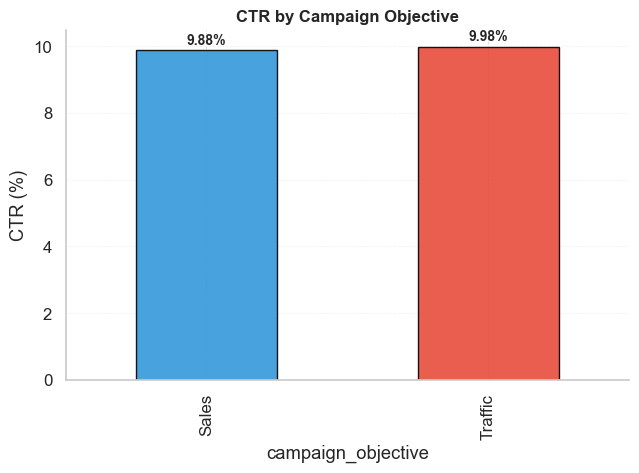

In [140]:
# ========================================
# ANALISIS A.2: BY CAMPAIGN OBJECTIVE
# ========================================
print("\n" + "="*50)
print("ANALISIS A.2: BY OBJECTIVE")
print("="*50)

ctr_by_objective = df_kpi.groupby('campaign_objective').agg({
    'impressions': 'sum', 'clicks': 'sum', 
    'amount_spent': 'sum', 'purchase': 'sum'
})

# Hitung ulang rasio untuk grup
ctr_by_objective['CTR'] = (ctr_by_objective['clicks'] / ctr_by_objective['impressions']) * 100
ctr_by_objective['CPC'] = ctr_by_objective['amount_spent'] / ctr_by_objective['clicks']
ctr_by_objective['CVR'] = (ctr_by_objective['purchase'] / ctr_by_objective['clicks']) * 100

print(ctr_by_objective[['CTR', 'CPC', 'CVR']].round(2))

fig = plt.figure(figsize=(16, 10))

# Plot 1: CTR by Objective
ax1 = plt.subplot(2, 2, 1)
ctr_by_objective['CTR'].plot(kind='bar', ax=ax1, color=['#3498db', '#e74c3c'], alpha=0.9, edgecolor='black')
ax1.set_title('CTR by Campaign Objective', fontweight='bold', fontsize=12)
ax1.set_ylabel('CTR (%)')
ax1.grid(axis='y', alpha=0.3)

# Logika menambah label persen di atas batang
for p in ax1.patches:
    value = p.get_height()
    ax1.annotate(f'{value:.2f}%', 
                 (p.get_x() + p.get_width() / 2., value), 
                 ha='center', va='bottom', 
                 xytext=(0, 2), textcoords='offset points', 
                 fontweight='bold', fontsize=10)

In [141]:
# ========================================
# A.3: Total Purchase Value (Omzet)
# ========================================

total_omzet = df_kpi["purchase_value"].sum()

print("="*50)
print("A.3 Total Purchase Value (Omzet)")
print("="*50)
print(f"Total Omzet dari iklan: {total_omzet:,.0f}")


A.3 Total Purchase Value (Omzet)
Total Omzet dari iklan: 10,450,212,835


In [142]:
# ========================================
# A.4: Overall ROAS (Return on Advertising Spend)
# ROAS = Total Omzet / Total Ad Spend
# ========================================

total_spent = df_kpi["amount_spent"].sum()
total_omzet = df_kpi["purchase_value"].sum()

overall_roas = total_omzet / total_spent if total_spent != 0 else np.nan

print("="*50)
print("A.4 Overall ROAS")
print("="*50)
print(f"Total Spend: {total_spent:,.0f}")
print(f"Total Omzet: {total_omzet:,.0f}")
print(f"Overall ROAS: {overall_roas:.4f}")


A.4 Overall ROAS
Total Spend: 12,952,655,222
Total Omzet: 10,450,212,835
Overall ROAS: 0.8068


In [143]:
# ========================================
# A.3 & A.4: OMZET & ROAS (TANPA FUNGSI)
# ========================================
print("\n" + "="*80)
print("A.3 & A.4: PURCHASE VALUE (OMZET) & ROAS")
print("="*80)

# -------------------------
# A.3 Total Purchase Value (Omzet)
# -------------------------
total_omzet = df_kpi["purchase_value"].sum()

print("\n3. Total Purchase Value (Omzet):")
print(f"   Total Omzet dari iklan: Rp {total_omzet:,.0f}")

# Breakdown omzet per campaign objective (Traffic vs Sales)
omzet_by_objective = df_kpi.groupby("campaign_objective")["purchase_value"].sum().sort_values(ascending=False)

print("\n   Purchase Value by Campaign Objective:")
for obj, val in omzet_by_objective.items():
    share = (val / total_omzet * 100) if total_omzet != 0 else np.nan
    print(f"   - {obj}: Rp {val:,.0f} ({share:.2f}%)")

# (Opsional) Tampilkan objective dengan omzet terbesar
if len(omzet_by_objective) > 0:
    top_obj = omzet_by_objective.index[0]
    print(f"\n   Objective dengan kontribusi omzet terbesar: {top_obj}")

# -------------------------
# A.4 ROAS Keseluruhan
# ROAS = Total Omzet / Total Ad Spend
# -------------------------
total_spent = df_kpi["amount_spent"].sum()
overall_roas = (total_omzet / total_spent) if total_spent != 0 else np.nan

print("\n4. ROAS (Return on Advertising Spend) Keseluruhan:")
print(f"   Total Spend: Rp {total_spent:,.0f}")
print(f"   Total Omzet: Rp {total_omzet:,.0f}")
print(f"   Overall ROAS: {overall_roas:.4f}")

# Interpretasi singkat ROAS
if pd.notna(overall_roas):
    if overall_roas >= 1:
        print(f"   (Setiap Rp 1 iklan menghasilkan Rp {overall_roas:.2f} revenue → cenderung profitable/break-even)")
    else:
        print(f"   (Setiap Rp 1 iklan hanya menghasilkan Rp {overall_roas:.2f} revenue → belum menutup biaya iklan)")
else:
    print("   ROAS tidak bisa dihitung karena total spend = 0")

# (Opsional) ROAS by objective sebagai konteks
roas_by_objective = df_kpi.groupby("campaign_objective").agg({
    "purchase_value": "sum",
    "amount_spent": "sum"
})
roas_by_objective["ROAS"] = roas_by_objective["purchase_value"] / roas_by_objective["amount_spent"]
roas_by_objective.replace([np.inf, -np.inf], np.nan, inplace=True)

print("\n   ROAS by Campaign Objective:")
print(roas_by_objective[["ROAS"]].round(4))



A.3 & A.4: PURCHASE VALUE (OMZET) & ROAS

3. Total Purchase Value (Omzet):
   Total Omzet dari iklan: Rp 10,450,212,835

   Purchase Value by Campaign Objective:
   - Sales: Rp 10,450,212,835 (100.00%)
   - Traffic: Rp 0 (0.00%)

   Objective dengan kontribusi omzet terbesar: Sales

4. ROAS (Return on Advertising Spend) Keseluruhan:
   Total Spend: Rp 12,952,655,222
   Total Omzet: Rp 10,450,212,835
   Overall ROAS: 0.8068
   (Setiap Rp 1 iklan hanya menghasilkan Rp 0.81 revenue → belum menutup biaya iklan)

   ROAS by Campaign Objective:
                      ROAS
campaign_objective        
Sales               1.6184
Traffic             0.0000


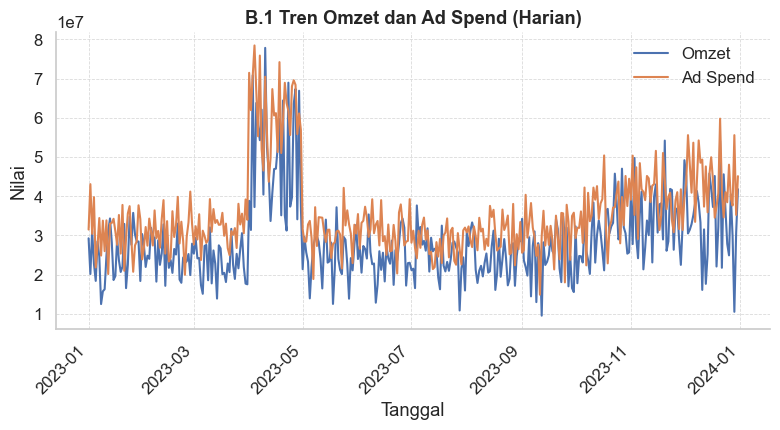

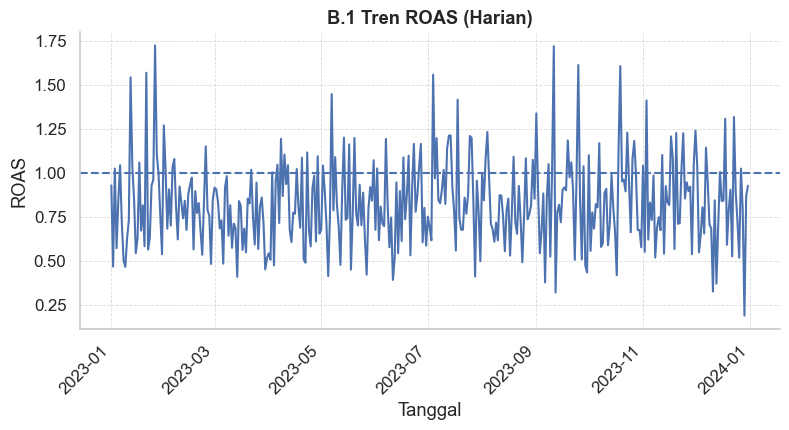


=== B.2 Tabel performa bulanan (termasuk growth MoM) ===


,month,omzet,spend,impressions,clicks,purchase,ROAS,CTR_%,omzet_mom_growth_%
0,2023-01,7.780761e+08,9.491030e+08,205401034,21047861,96679,0.82,10.25,NaN
1,2023-02,6.951760e+08,8.681966e+08,186341020,18928311,84867,0.80,10.16,-10.65
2,2023-03,7.125986e+08,9.863171e+08,212655422,19798148,96326,0.72,9.31,2.51
3,2023-04,1.494403e+09,1.853354e+09,403560268,39936876,186292,0.81,9.90,109.71
4,2023-05,7.651272e+08,9.487109e+08,208742580,20862359,97867,0.81,9.99,-48.80
5,2023-06,7.385859e+08,9.451684e+08,199443156,19805458,89365,0.78,9.93,-3.47
6,2023-07,7.639872e+08,8.668428e+08,200457562,20756372,94269,0.88,10.35,3.44
7,2023-08,7.572559e+08,9.437389e+08,205909861,19732038,97632,0.80,9.58,-0.88
8,2023-09,7.336739e+08,9.024532e+08,195619185,19397292,90750,0.81,9.92,-3.11
9,2023-10,9.347719e+08,1.124950e+09,250584653,24345766,107283,0.83,9.72,27.41



=== B.2 Top 3 bulan dengan peningkatan omzet terbesar (MoM) ===


,month,omzet,omzet_mom_growth_%,ROAS,spend
3,2023-04,1.494403e+09,109.71,0.81,1.853354e+09
9,2023-10,9.347719e+08,27.41,0.83,1.124950e+09
10,2023-11,1.021654e+09,9.29,0.85,1.203432e+09


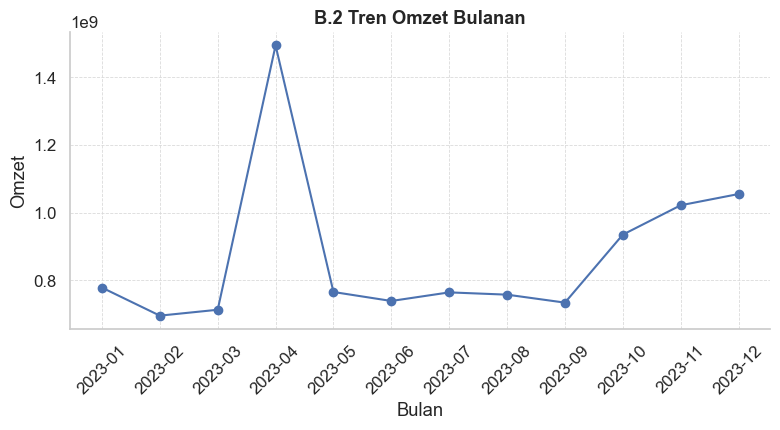

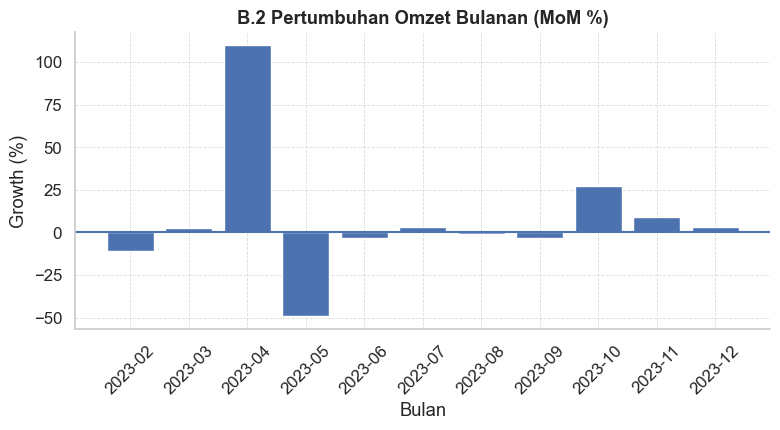


=== B.3 Tabel rata-rata omzet per bulan (indikasi seasonality) ===


,month_name,avg_omzet
4,January,2091602.39
3,February,2068976.04
7,March,1915587.54
0,April,4151120.72
8,May,2056793.49
6,June,2051627.50
5,July,2053729.09
1,August,2035634.25
11,September,2037983.05
10,October,2512827.62


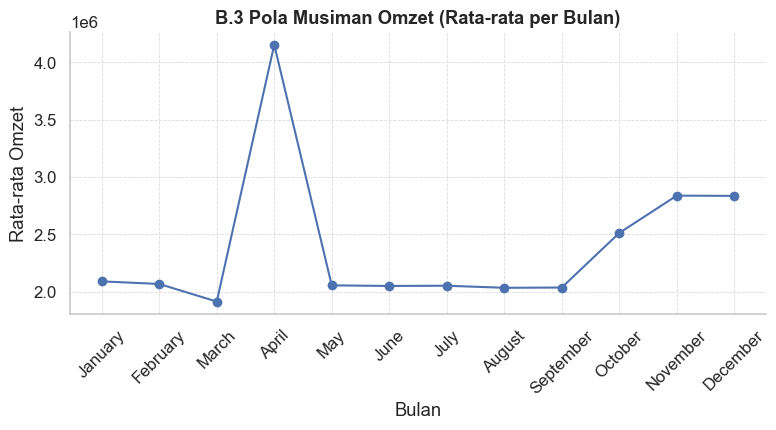

In [144]:
# ========================================
# ANALISIS B: Trend & Time Series Analysis
# ========================================

# --- Safety checks ---
required = ["created_date", "purchase_value", "amount_spent", "impressions", "clicks", "purchase"]
missing = [c for c in required if c not in df_kpi.columns]
if missing:
    raise ValueError(f"Kolom berikut tidak ada di df_kpi: {missing}")

# Pastikan created_date datetime
df_kpi["created_date"] = pd.to_datetime(df_kpi["created_date"], errors="coerce")

# Buat kolom month kalau belum ada
if "month" not in df_kpi.columns:
    df_kpi["month"] = df_kpi["created_date"].dt.to_period("M").astype(str)

# =========================
# B.1 Tren performa dari waktu ke waktu (Daily)
# =========================
daily_perf = (
    df_kpi.groupby("created_date", as_index=False)
          .agg(
              omzet=("purchase_value", "sum"),
              spend=("amount_spent", "sum"),
              impressions=("impressions", "sum"),
              clicks=("clicks", "sum"),
              purchase=("purchase", "sum")
          )
)

daily_perf["ROAS"] = daily_perf["omzet"] / daily_perf["spend"]
daily_perf["CTR_%"] = (daily_perf["clicks"] / daily_perf["impressions"]) * 100
daily_perf.replace([np.inf, -np.inf], np.nan, inplace=True)

# Visual 1: Omzet & Spend harian
plt.figure()
plt.plot(daily_perf["created_date"], daily_perf["omzet"], label="Omzet")
plt.plot(daily_perf["created_date"], daily_perf["spend"], label="Ad Spend")
plt.title("B.1 Tren Omzet dan Ad Spend (Harian)")
plt.xlabel("Tanggal")
plt.ylabel("Nilai")
plt.legend()
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Visual 2: ROAS harian
plt.figure()
plt.plot(daily_perf["created_date"], daily_perf["ROAS"])
plt.axhline(1, linestyle="--")
plt.title("B.1 Tren ROAS (Harian)")
plt.xlabel("Tanggal")
plt.ylabel("ROAS")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# =========================
# B.2 Bulan/Periode peningkatan signifikan (Monthly + MoM growth)
# =========================
monthly_perf = (
    df_kpi.groupby("month", as_index=False)
          .agg(
              omzet=("purchase_value", "sum"),
              spend=("amount_spent", "sum"),
              impressions=("impressions", "sum"),
              clicks=("clicks", "sum"),
              purchase=("purchase", "sum")
          )
)

monthly_perf["ROAS"] = monthly_perf["omzet"] / monthly_perf["spend"]
monthly_perf["CTR_%"] = (monthly_perf["clicks"] / monthly_perf["impressions"]) * 100
monthly_perf.replace([np.inf, -np.inf], np.nan, inplace=True)

# Growth MoM omzet
monthly_perf["omzet_mom_growth_%"] = monthly_perf["omzet"].pct_change() * 100

print("\n=== B.2 Tabel performa bulanan (termasuk growth MoM) ===")
display(monthly_perf.round(2))

# Bulan dengan peningkatan signifikan = Top 3 growth positif terbesar
sig_increase = (
    monthly_perf.dropna(subset=["omzet_mom_growth_%"])
               .sort_values("omzet_mom_growth_%", ascending=False)
               .head(3)[["month", "omzet", "omzet_mom_growth_%", "ROAS", "spend"]]
)
print("\n=== B.2 Top 3 bulan dengan peningkatan omzet terbesar (MoM) ===")
display(sig_increase.round(2))

# Visual 3: Tren omzet bulanan
plt.figure()
plt.plot(monthly_perf["month"], monthly_perf["omzet"], marker="o")
plt.title("B.2 Tren Omzet Bulanan")
plt.xlabel("Bulan")
plt.ylabel("Omzet")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Visual 4: Growth MoM bulanan
plt.figure()
plt.bar(monthly_perf["month"], monthly_perf["omzet_mom_growth_%"])
plt.axhline(0)
plt.title("B.2 Pertumbuhan Omzet Bulanan (MoM %)")
plt.xlabel("Bulan")
plt.ylabel("Growth (%)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# =========================
# B.3 Seasonality (pola musiman) - rata-rata omzet per nama bulan
# =========================
df_kpi["month_name"] = df_kpi["created_date"].dt.month_name()

seasonality = (
    df_kpi.groupby("month_name", as_index=False)
          .agg(avg_omzet=("purchase_value", "mean"))
)

month_order = [
    "January","February","March","April","May","June",
    "July","August","September","October","November","December"
]
seasonality["month_name"] = pd.Categorical(seasonality["month_name"], categories=month_order, ordered=True)
seasonality = seasonality.sort_values("month_name")

print("\n=== B.3 Tabel rata-rata omzet per bulan (indikasi seasonality) ===")
display(seasonality.round(2))

# Visual 5: Seasonality plot
plt.figure()
plt.plot(seasonality["month_name"], seasonality["avg_omzet"], marker="o")
plt.title("B.3 Pola Musiman Omzet (Rata-rata per Bulan)")
plt.xlabel("Bulan")
plt.ylabel("Rata-rata Omzet")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



ANALISIS B: TREND & TIME SERIES

[B.1] Tren Performa Iklan dari Waktu ke Waktu
Periode data: 2023-01-01 s/d 2023-12-31
Total hari: 365


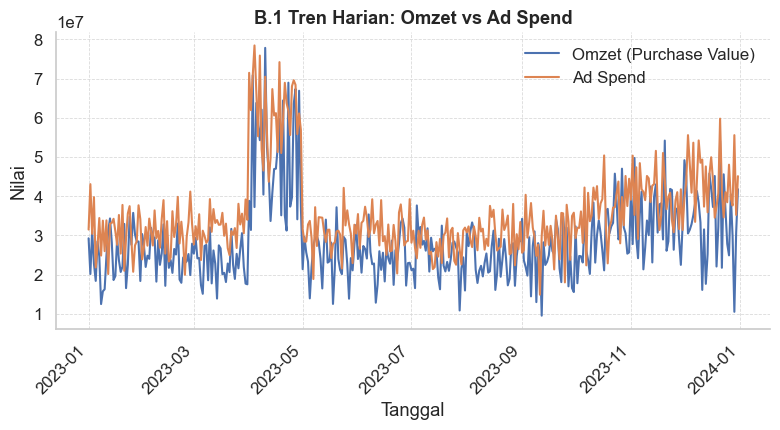

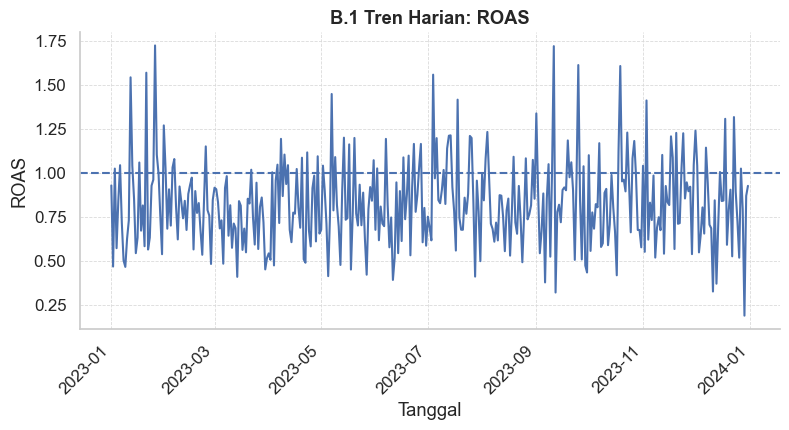


Ringkasan performa bulanan (CTR, ROAS, Omzet, Spend):


,year,month_name,CTR_%,ROAS,purchase_value,amount_spent
0,2023,January,10.25,0.82,7.780761e+08,9.491030e+08
1,2023,February,10.16,0.80,6.951760e+08,8.681966e+08
2,2023,March,9.31,0.72,7.125986e+08,9.863171e+08
3,2023,April,9.90,0.81,1.494403e+09,1.853354e+09
4,2023,May,9.99,0.81,7.651272e+08,9.487109e+08
5,2023,June,9.93,0.78,7.385859e+08,9.451684e+08
6,2023,July,10.35,0.88,7.639872e+08,8.668428e+08
7,2023,August,9.58,0.80,7.572559e+08,9.437389e+08
8,2023,September,9.92,0.81,7.336739e+08,9.024532e+08
9,2023,October,9.72,0.83,9.347719e+08,1.124950e+09


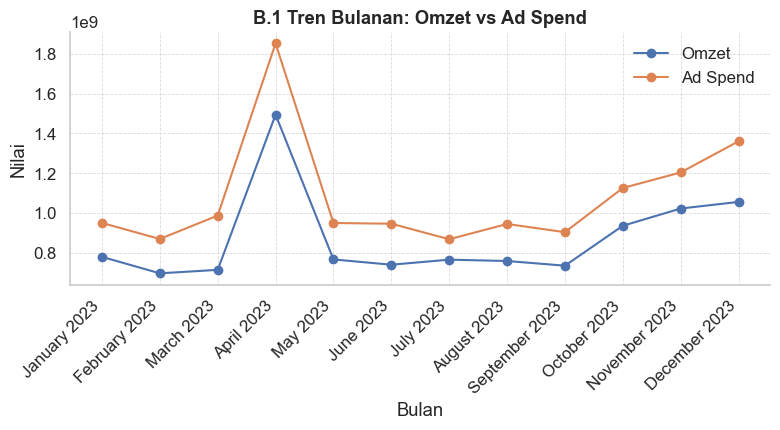

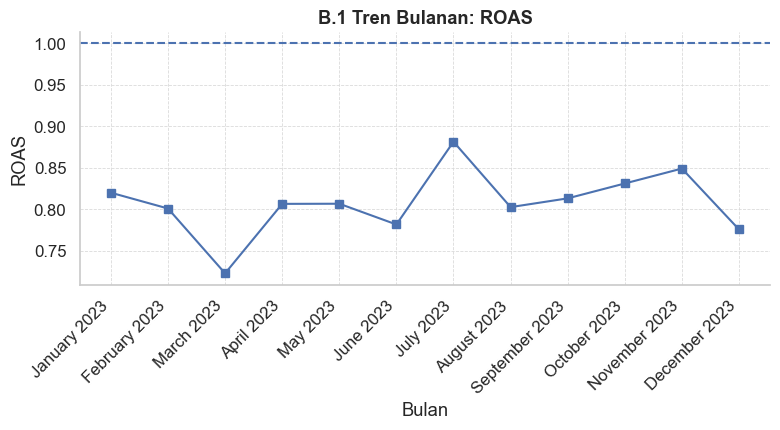


[B.2] Bulan/Periode dengan Peningkatan Signifikan

Bulan dengan perubahan signifikan (>= 10% pada omzet/ROAS):


,month_label,purchase_value,omzet_mom_%,ROAS,roas_mom_%
1,February 2023,6.951760e+08,-10.65,0.80,-2.33
3,April 2023,1.494403e+09,109.71,0.81,11.60
4,May 2023,7.651272e+08,-48.80,0.81,0.02
6,July 2023,7.639872e+08,3.44,0.88,12.79
9,October 2023,9.347719e+08,27.41,0.83,2.21



Top 3 bulan dengan kenaikan omzet terbesar (MoM):


,month_label,purchase_value,omzet_mom_%,ROAS,amount_spent
3,April 2023,1.494403e+09,109.71,0.81,1.853354e+09
9,October 2023,9.347719e+08,27.41,0.83,1.124950e+09
10,November 2023,1.021654e+09,9.29,0.85,1.203432e+09


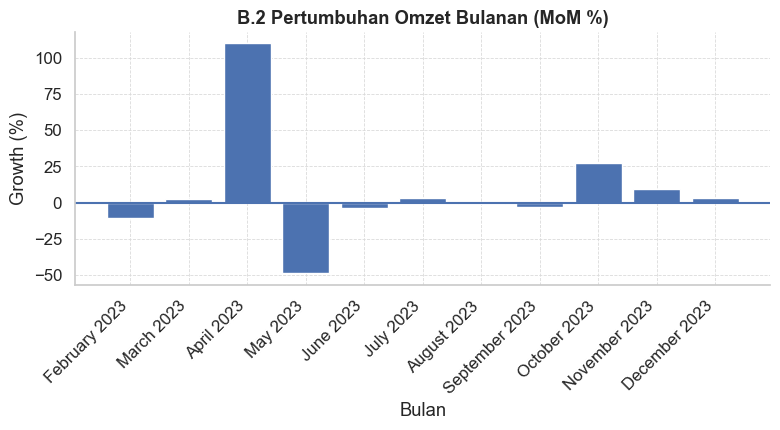


[B.3] Pola Musiman (Seasonality) yang Mempengaruhi Omzet

Tabel seasonality (Total & Avg Omzet, ROAS):


,total_omzet,avg_omzet,total_spent,ROAS
month_name,,,,
January,7.780761e+08,2091602.39,9.491030e+08,0.82
February,6.951760e+08,2068976.04,8.681966e+08,0.80
March,7.125986e+08,1915587.54,9.863171e+08,0.72
April,1.494403e+09,4151120.72,1.853354e+09,0.81
May,7.651272e+08,2056793.49,9.487109e+08,0.81
June,7.385859e+08,2051627.50,9.451684e+08,0.78
July,7.639872e+08,2053729.09,8.668428e+08,0.88
August,7.572559e+08,2035634.25,9.437389e+08,0.80
September,7.336739e+08,2037983.05,9.024532e+08,0.81



Bulan omzet tertinggi: April
Bulan omzet terendah: February


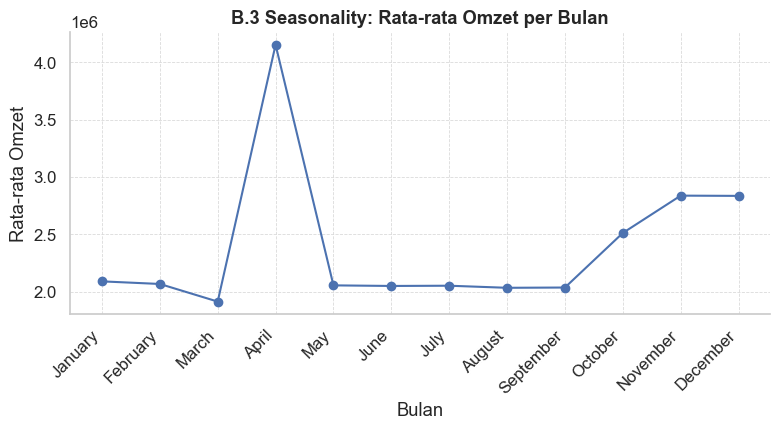

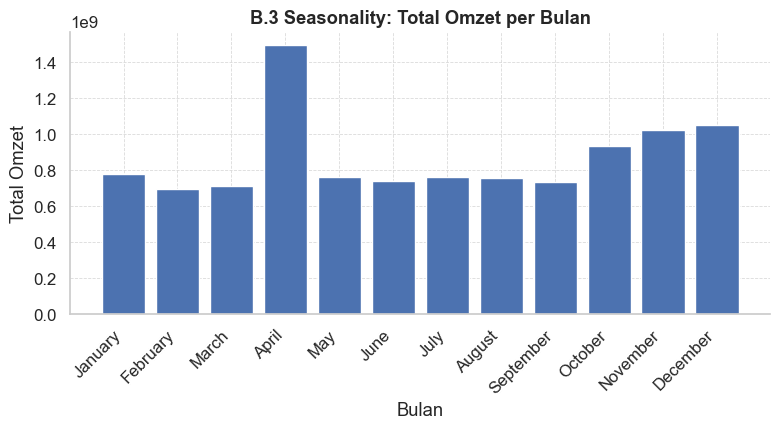

In [145]:
# ========================================
# 5. ANALISIS B: TREND & TIME SERIES
# ========================================
print("\n" + "="*50)
print("ANALISIS B: TREND & TIME SERIES")
print("="*50)

# --- Safety: pastikan kolom waktu ada ---
df_kpi["created_date"] = pd.to_datetime(df_kpi["created_date"], errors="coerce")

if "year" not in df_kpi.columns:
    df_kpi["year"] = df_kpi["created_date"].dt.year
if "month" not in df_kpi.columns:
    df_kpi["month"] = df_kpi["created_date"].dt.month
if "month_name" not in df_kpi.columns:
    df_kpi["month_name"] = df_kpi["created_date"].dt.strftime("%B")

# ========================================
# B.1 Tren performa iklan dari waktu ke waktu
# ========================================
print("\n[B.1] Tren Performa Iklan dari Waktu ke Waktu")

# Agregasi harian
daily_perf = df_kpi.groupby("created_date").agg({
    "impressions": "sum",
    "clicks": "sum",
    "purchase": "sum",
    "purchase_value": "sum",
    "amount_spent": "sum"
})

# KPI harian (ratio of sums)
daily_perf["CTR_%"] = (daily_perf["clicks"] / daily_perf["impressions"]) * 100
daily_perf["ROAS"]  = daily_perf["purchase_value"] / daily_perf["amount_spent"]
daily_perf.replace([np.inf, -np.inf], np.nan, inplace=True)

print(f"Periode data: {df_kpi['created_date'].min().date()} s/d {df_kpi['created_date'].max().date()}")
print(f"Total hari: {len(daily_perf)}")

# Visual (harian): omzet vs spend
plt.figure()
plt.plot(daily_perf.index, daily_perf["purchase_value"], label="Omzet (Purchase Value)")
plt.plot(daily_perf.index, daily_perf["amount_spent"], label="Ad Spend")
plt.title("B.1 Tren Harian: Omzet vs Ad Spend")
plt.xlabel("Tanggal")
plt.ylabel("Nilai")
plt.legend()
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Visual (harian): ROAS
plt.figure()
plt.plot(daily_perf.index, daily_perf["ROAS"])
plt.axhline(1, linestyle="--")
plt.title("B.1 Tren Harian: ROAS")
plt.xlabel("Tanggal")
plt.ylabel("ROAS")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Agregasi bulanan
monthly_perf = df_kpi.groupby(["year", "month", "month_name"]).agg({
    "impressions": "sum",
    "clicks": "sum",
    "purchase": "sum",
    "purchase_value": "sum",
    "amount_spent": "sum"
}).reset_index()

# urutkan agar time-series rapi
monthly_perf = monthly_perf.sort_values(["year", "month"]).reset_index(drop=True)

monthly_perf["CTR_%"] = (monthly_perf["clicks"] / monthly_perf["impressions"]) * 100
monthly_perf["ROAS"]  = monthly_perf["purchase_value"] / monthly_perf["amount_spent"]
monthly_perf.replace([np.inf, -np.inf], np.nan, inplace=True)

print("\nRingkasan performa bulanan (CTR, ROAS, Omzet, Spend):")
display(monthly_perf[["year","month_name","CTR_%","ROAS","purchase_value","amount_spent"]].round(2))

# label x untuk plot bulanan
monthly_perf["month_label"] = monthly_perf["month_name"] + " " + monthly_perf["year"].astype(str)

# Visual (bulanan): omzet vs spend
plt.figure()
plt.plot(monthly_perf["month_label"], monthly_perf["purchase_value"], marker="o", label="Omzet")
plt.plot(monthly_perf["month_label"], monthly_perf["amount_spent"], marker="o", label="Ad Spend")
plt.title("B.1 Tren Bulanan: Omzet vs Ad Spend")
plt.xlabel("Bulan")
plt.ylabel("Nilai")
plt.xticks(rotation=45, ha="right")
plt.legend()
plt.tight_layout()
plt.show()

# Visual (bulanan): ROAS
plt.figure()
plt.plot(monthly_perf["month_label"], monthly_perf["ROAS"], marker="s")
plt.axhline(1, linestyle="--")
plt.title("B.1 Tren Bulanan: ROAS")
plt.xlabel("Bulan")
plt.ylabel("ROAS")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# ========================================
# B.2 Bulan/periode peningkatan signifikan
# ========================================
print("\n[B.2] Bulan/Periode dengan Peningkatan Signifikan")

monthly_perf["omzet_mom_%"] = monthly_perf["purchase_value"].pct_change() * 100
monthly_perf["roas_mom_%"]  = monthly_perf["ROAS"].pct_change() * 100

# Threshold signifikan (kamu bisa ganti)
SIG_THRESHOLD = 10

significant_months = monthly_perf[
    (monthly_perf["omzet_mom_%"].abs() >= SIG_THRESHOLD) |
    (monthly_perf["roas_mom_%"].abs()  >= SIG_THRESHOLD)
].copy()

if len(significant_months) > 0:
    print(f"\nBulan dengan perubahan signifikan (>= {SIG_THRESHOLD}% pada omzet/ROAS):")
    display(significant_months[["month_label","purchase_value","omzet_mom_%","ROAS","roas_mom_%"]].round(2))
else:
    print(f"Tidak ada perubahan signifikan (>= {SIG_THRESHOLD}%) terdeteksi.")

# Top 3 kenaikan omzet terbesar
top_increase = monthly_perf.dropna(subset=["omzet_mom_%"]).sort_values("omzet_mom_%", ascending=False).head(3)
print("\nTop 3 bulan dengan kenaikan omzet terbesar (MoM):")
display(top_increase[["month_label","purchase_value","omzet_mom_%","ROAS","amount_spent"]].round(2))

# Visual: growth MoM omzet
plt.figure()
plt.bar(monthly_perf["month_label"], monthly_perf["omzet_mom_%"])
plt.axhline(0)
plt.title("B.2 Pertumbuhan Omzet Bulanan (MoM %)")
plt.xlabel("Bulan")
plt.ylabel("Growth (%)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# ========================================
# B.3 Seasonality (pola musiman)
# ========================================
print("\n[B.3] Pola Musiman (Seasonality) yang Mempengaruhi Omzet")

seasonal = df_kpi.groupby("month_name").agg({
    "purchase_value": ["sum", "mean"],
    "amount_spent": "sum"
})
seasonal.columns = ["total_omzet", "avg_omzet", "total_spent"]
seasonal["ROAS"] = seasonal["total_omzet"] / seasonal["total_spent"]
seasonal.replace([np.inf, -np.inf], np.nan, inplace=True)

# Urutkan bulan sesuai kalender
month_order = ["January","February","March","April","May","June",
               "July","August","September","October","November","December"]
seasonal = seasonal.reindex([m for m in month_order if m in seasonal.index])

print("\nTabel seasonality (Total & Avg Omzet, ROAS):")
display(seasonal.round(2))

best_month = seasonal["total_omzet"].idxmax()
worst_month = seasonal["total_omzet"].idxmin()
print(f"\nBulan omzet tertinggi: {best_month}")
print(f"Bulan omzet terendah: {worst_month}")

# Visual: avg omzet per bulan
plt.figure()
plt.plot(seasonal.index, seasonal["avg_omzet"], marker="o")
plt.title("B.3 Seasonality: Rata-rata Omzet per Bulan")
plt.xlabel("Bulan")
plt.ylabel("Rata-rata Omzet")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Visual: total omzet per bulan
plt.figure()
plt.bar(seasonal.index, seasonal["total_omzet"])
plt.title("B.3 Seasonality: Total Omzet per Bulan")
plt.xlabel("Bulan")
plt.ylabel("Total Omzet")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [146]:
# ========================================
# 6. ANALISIS C: INDUSTRY & ACCOUNT
# ========================================
print("\n" + "="*50)
print("ANALISIS C: INDUSTRY & ACCOUNT")
print("="*50)

# Performa Industri
industry_perf = df_kpi.groupby('industry').agg({
    'purchase_value': ['sum', 'mean'],
    'impressions': 'sum', 'clicks': 'sum', 'amount_spent': 'sum'
})
industry_perf.columns = ['total_omzet', 'avg_omzet', 'impressions', 'clicks', 'amount_spent']
industry_perf['ROAS'] = industry_perf['total_omzet'] / industry_perf['amount_spent']
industry_perf = industry_perf.sort_values('avg_omzet', ascending=False)

print("\nTop Industri (Avg Omzet):")
print(industry_perf[['avg_omzet', 'ROAS']].head(3))

# Performa Akun
account_perf = df_kpi.groupby('account_name')[['purchase_value', 'amount_spent']].sum()
account_perf = account_perf.sort_values('purchase_value', ascending=False)

print("\nTop 5 Akun (Revenue):")
print(account_perf.head())


ANALISIS C: INDUSTRY & ACCOUNT

Top Industri (Avg Omzet):
             avg_omzet      ROAS
industry                        
Beauty    2.398943e+06  0.812835
Fashion   2.389952e+06  0.801893
FMCG      2.368784e+06  0.805718

Top 5 Akun (Revenue):
                    purchase_value  amount_spent
account_name                                    
Client C - Fashion    1.779702e+09  2.127994e+09
Client D - Beauty     1.762483e+09  2.214683e+09
Client B - Beauty     1.739974e+09  2.094255e+09
Client E - FMCG       1.739546e+09  2.140263e+09
Client F - FMCG       1.718880e+09  2.152087e+09



C1. Industri dengan Rata-rata Omzet Tertinggi
           avg_omzet  ROAS
industry                  
Beauty    2398943.13  0.81
Fashion   2389952.49  0.80
FMCG      2368784.41  0.81


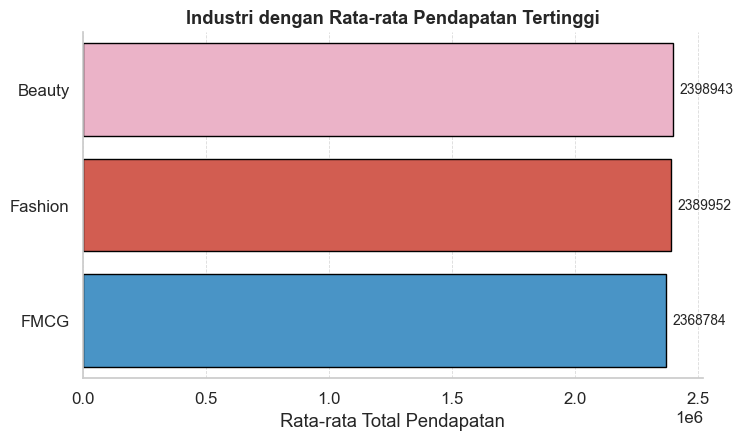

In [164]:
sns.set_theme(style="whitegrid", font_scale=1.1)

plt.rcParams.update({
    "figure.figsize": (8, 4.5),
    "axes.spines.top": False,
    "axes.spines.right": False,
    "grid.color": "#DADADA",
    "grid.linestyle": "--",
    "grid.linewidth": 0.6,
    "axes.titleweight": "bold"
})

def add_labels(ax, fmt="{:.0f}"):
    xmax = ax.get_xlim()[1]
    offset = xmax * 0.01
    
    for p in ax.patches:
        v = p.get_width()
        ax.text(
            v + offset,
            p.get_y() + p.get_height()/2,
            fmt.format(v),
            va="center",
            fontsize=10
        )

industry_colors = {
    'Beauty': '#F5A9C6',
    'Fashion': '#E74C3C',
    'FMCG': '#3498DB'
}

num_cols = ['clicks','impressions','purchase','purchase_value','amount_spent']
df[num_cols] = df[num_cols].apply(pd.to_numeric, errors='coerce')

# ===============================
# C1 – AVG OMZET INDUSTRI
# ===============================
industry_perf = (
    df.groupby('industry')
      .agg(
          avg_omzet=('purchase_value', 'mean'),
          total_omzet=('purchase_value', 'sum'),
          total_spent=('amount_spent', 'sum')
      )
      .dropna()
)

industry_perf['ROAS'] = industry_perf['total_omzet'] / industry_perf['total_spent']
industry_perf = industry_perf.sort_values('avg_omzet', ascending=False)

print("\nC1. Industri dengan Rata-rata Omzet Tertinggi")
print(industry_perf[['avg_omzet', 'ROAS']].round(2))

top_industry_avg = industry_perf.head(5)

plt.figure()
colors = [industry_colors.get(ind, '#95A5A6') for ind in top_industry_avg.index]
ax = sns.barplot(
    x=top_industry_avg['avg_omzet'],
    y=top_industry_avg.index,
    hue=top_industry_avg.index,
    palette=colors,
)

for bar in ax.patches:
    bar.set_edgecolor('black')
    bar.set_linewidth(1)

ax.set_title("Industri dengan Rata-rata Pendapatan Tertinggi", weight='bold')
ax.set_xlabel("Rata-rata Total Pendapatan")
ax.set_ylabel("")
add_labels(ax)

plt.show()



C2. Akun Paling Efektif Menghasilkan Revenue
                    total_revenue  ROAS
account_name                           
Client C - Fashion   1.779702e+09  0.84
Client D - Beauty    1.762483e+09  0.80
Client B - Beauty    1.739974e+09  0.83
Client E - FMCG      1.739546e+09  0.81
Client F - FMCG      1.718880e+09  0.80
Client A - Fashion   1.709628e+09  0.77


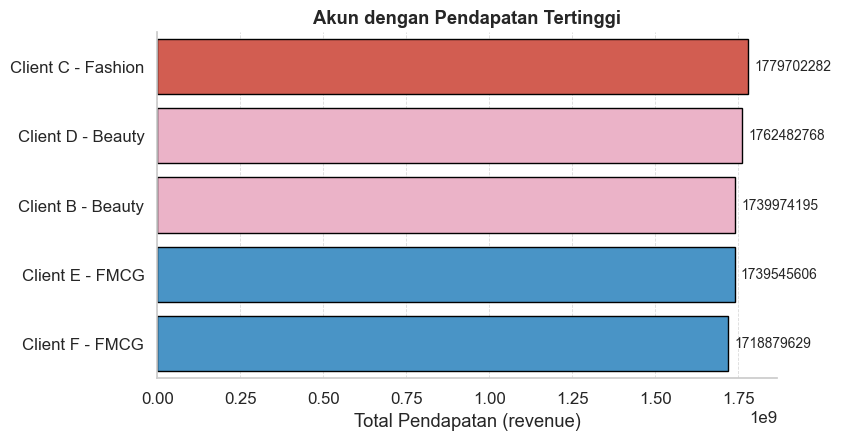

In [160]:
# ===============================
# C2 – AKUN PALING EFEKTIF
# ===============================
account_perf = (
    df.groupby(['account_name', 'industry'])
      .agg(
          total_revenue=('purchase_value', 'sum'),
          total_spent=('amount_spent', 'sum')
      )
      .dropna()
      .reset_index()
)

account_perf['ROAS'] = account_perf['total_revenue'] / account_perf['total_spent']
account_perf = account_perf.sort_values('total_revenue', ascending=False)

print("\nC2. Akun Paling Efektif Menghasilkan Revenue")
print(account_perf.set_index('account_name')[['total_revenue', 'ROAS']].round(2))

top_accounts = account_perf.head(5)

plt.figure()
colors = [industry_colors.get(ind, '#95A5A6') for ind in top_accounts['industry']]
ax = sns.barplot(
    data=top_accounts,
    x='total_revenue',
    y='account_name',
    hue='account_name',    
    palette=colors,
)

for bar in ax.patches:
    bar.set_edgecolor('black')
    bar.set_linewidth(1)

ax.set_title("Akun dengan Pendapatan Tertinggi", weight='bold')
ax.set_xlabel("Total Pendapatan (revenue)")
ax.set_ylabel("")
add_labels(ax)
plt.show()




C3. Industri dengan ROAS Tertinggi
           ROAS   total_omzet
industry                     
Beauty    0.813  3.502457e+09
FMCG      0.806  3.458425e+09
Fashion   0.802  3.489331e+09


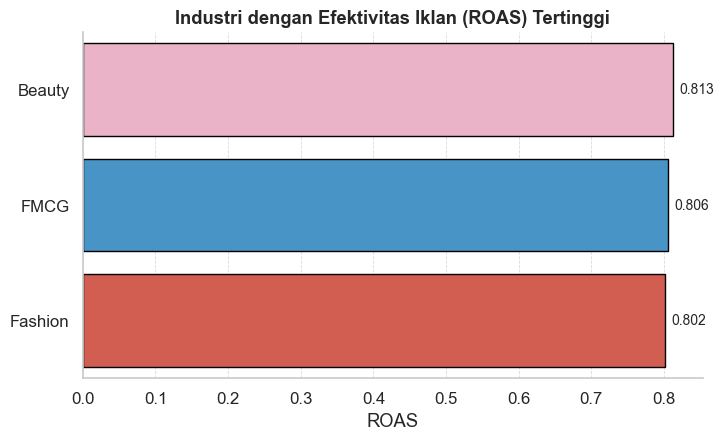

In [161]:

# ===============================
# C3 – INDUSTRI DENGAN ROAS TERTINGGI
# ===============================
industry_roas = industry_perf.sort_values('ROAS', ascending=False)

print("\nC3. Industri dengan ROAS Tertinggi")
print(industry_roas[['ROAS', 'total_omzet']].round(3))

top_industry_roas = industry_roas.head(5)

plt.figure()
colors = [industry_colors.get(ind, '#95A5A6') for ind in top_industry_roas.index]
ax = sns.barplot(
    x=top_industry_roas['ROAS'],
    y=top_industry_roas.index,
    hue=top_industry_roas.index,
    palette=colors,
)

for bar in ax.patches:
    bar.set_edgecolor('black')
    bar.set_linewidth(1)

ax.set_title("Industri dengan Efektivitas Iklan (ROAS) Tertinggi", weight='bold')
ax.set_xlabel("ROAS")
ax.set_ylabel("")
add_labels(ax, fmt="{:.3f}")
plt.show()


## **Exploratory Data Analysis (EDA)**

## **Insights Summary**

## **Business Recommendation**